# PhysiCOOL is cool and teaches you how parameter optimization works 🕶️

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

## Generating data
The first thing we need is to do is to generate some data, which we will be using to calibrate our model.

<IPython.core.display.Javascript object>


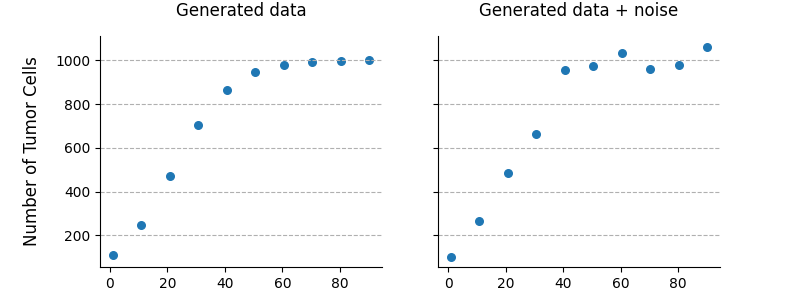

<AxesSubplot:title={'center':'Generated data + noise'}, xlabel='Time (Days)'>

In [139]:
# Generate logistic growth data
number_time_points = 10
time = np.arange(1, 100, (100-1)/number_time_points)

N_0 = 100
proliferation_time = 0.1
carrying_capacity = 1000
parameters = np.array([proliferation_time, carrying_capacity])

N_data = logistic_growth_model(N_0, time, parameters)

# Add noise to the generated data
data_noise = np.zeros((np.size(time)))
N_data_noise = np.zeros((np.size(time)))

for i in range(np.size(time)):
    data_noise = np.random.normal(0, 0.05*N_data[i] ,1)
    N_data_noise[i] = N_data[i] + data_noise

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=100, sharey=True)

plot_growth(time, N_data, axes[0], 'Generated data')
plot_growth(time, N_data_noise, axes[1], 'Generated data + noise', ylabel=False)

## Optimization
We have some data and some noised data... let's make it happen!

In [155]:
number_of_levels = 10
points_per_direction = 10
percent_per_direction = 0.5
about_point = np.array([0.09, 1000])

parameters_in_sweep = np.zeros((2,1))
objective_function = np.zeros((number_of_levels, points_per_direction, points_per_direction))
save_x = np.zeros((number_of_levels, points_per_direction))
save_y = np.zeros((number_of_levels, points_per_direction))

for n in range(number_of_levels):
    
    # Defining search bounds
    factor = percent_per_direction/(n*2+1)
    # Proliferation rate bounds
    min_prol_limit = about_point[0]-factor*about_point[0]
    max_prol_limit = about_point[0]+factor*about_point[0]
    prol_sweep = np.linspace(min_prol_limit, max_prol_limit, points_per_direction)
    # Carrying capacity bounds 
    min_carcap_limit = about_point[1]-factor*about_point[1]
    max_carcap_limit = about_point[1]+factor*about_point[1]
    carcap_sweep = np.linspace(min_carcap_limit, max_carcap_limit, points_per_direction)
    
    save_x[n] = prol_sweep
    save_y[n] = carcap_sweep
    
    # Sweep through the parameter combinations
    for a in range(points_per_direction):
        for b in range(points_per_direction):
            
            # Select parameters and run the model
            parameters_in_sweep[0] = prol_sweep[a]
            parameters_in_sweep[1] = carcap_sweep[b]
            N_model = logistic_growth_model(N_0, time, parameters_in_sweep)
            
            # Compute error
            objective_function[n][a][b] = sum_squared_diff(N_model, N_data)

    # Select best point in the parameter space
    # I is optimal index, but in references to a points_per_direction X points_per_direcion
    I = np.argmin(objective_function[n])
    x = int(np.floor(I/points_per_direction))
    y = int(I-points_per_direction*x)
    
    about_point[0] = prol_sweep[x]
    about_point[1] = carcap_sweep[y]
    
    new_x, new_y = [round(about_point[0], 4), round(about_point[1], 4)]
    error = objective_function[n].min()
    
    print(f'New point: {new_x}, {new_y}; error: {round(error, 3)}')

New point: 0.095, 1055.5556; error: 12164.807
New point: 0.1003, 996.9136; error: 39.515
New point: 0.0992, 1007.9904; error: 258.66
New point: 0.1, 999.9905; error: 0.263
New point: 0.0993, 1006.1633; error: 153.866
New point: 0.0998, 1001.0816; error: 4.906
New point: 0.1003, 996.8035; error: 42.899
New point: 0.0999, 1000.4954; error: 1.272
New point: 0.1002, 997.2258; error: 32.515
New point: 0.0999, 1000.1416; error: 0.446


## Visualization

<IPython.core.display.Javascript object>


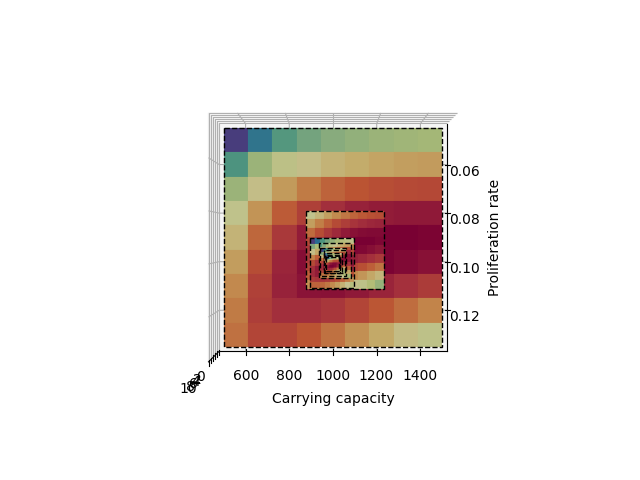

Text(0.0, -0.07635843947814007, 'Carrying capacity')

In [165]:
%matplotlib notebook
from matplotlib import cm, colors
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d

# Creating figure
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.view_init(elev=90, azim=0)

fig.show()
fig.canvas.draw()

for n in range(number_of_levels):
    
    # Get the parameter space
    x, y = np.meshgrid(save_x[n], save_y[n])
    
    width = max(save_x[n]) - min(save_x[n])
    heigth = max(save_y[n]) - min(save_y[n])
    
    p = Rectangle((min(save_x[n]), min(save_y[n])), width, heigth, 
                  edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=n)
    
    # Convert the error data to colormap
    color_dimension = objective_function[n] # change to desired fourth dimension
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm, cmap='Spectral')
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    # Plot surface using color as a 4th dimension
    ax.plot_surface(x, y, np.ones((len(prol_sweep), len(prol_sweep)))*n,
                    facecolors=fcolors,
                    edgecolors='white', linewidth=0.1, rstride=1, cstride=1,
                    vmin=minn, vmax=maxx)
    ax.set_zlim(0,10)
    ax.set_xlim(min(save_x[0]), max(save_x[0]))
    ax.set_ylim(min(save_y[0]), max(save_y[0]))
    
    fig.canvas.draw()
    

ax.set_xlabel('Proliferation rate', labelpad=10)
ax.set_ylabel('Carrying capacity', labelpad=10)
#ax.set_zlabel('Optimization level', labelpad=5)

#fig.colorbar(m, shrink=0.6)

<IPython.core.display.Javascript object>


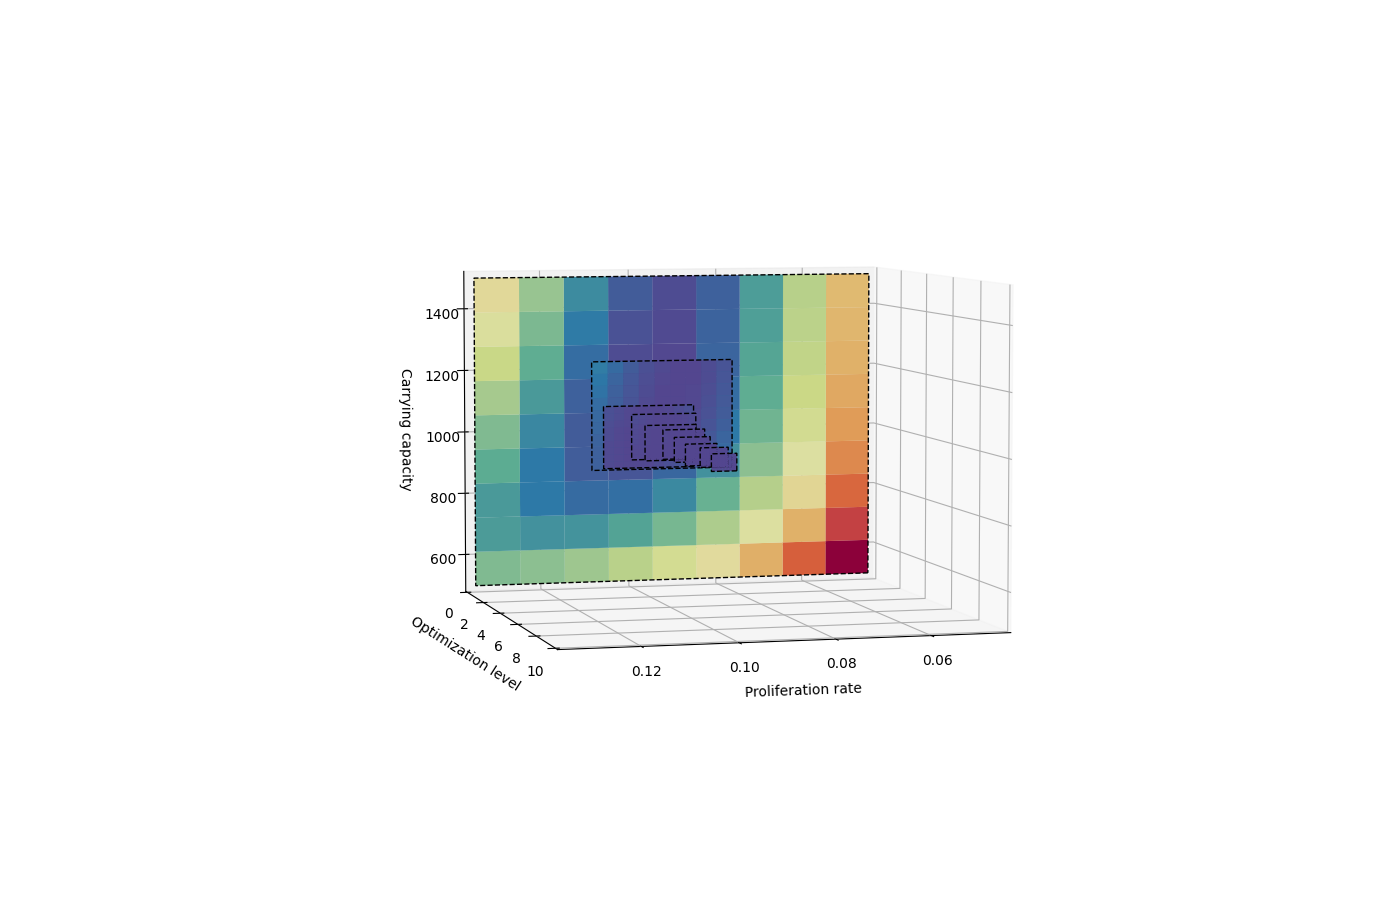

In [135]:
%matplotlib notebook
from matplotlib import cm, colors
import time

color_dimension = objective_function[0] # change to desired fourth dimension
maxx = color_dimension.max()
minn = 0
norm = colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='Spectral_r')

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

ax.view_init(elev=5., azim=75)

plt.ion()
fig.show()
fig.canvas.draw()

for n in range(number_of_levels):
    
    # Get the parameter space
    x, y = np.meshgrid(save_x[n], save_y[n])
    
    width = max(save_x[n]) - min(save_x[n])
    heigth = max(save_y[n]) - min(save_y[n])
    
    p = Rectangle((min(save_x[n]), min(save_y[n])), width, heigth, 
                  edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=n, zdir='y')
    
    # Convert the error data to colormap
    color_dimension = objective_function[n] # change to desired fourth dimension
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    # Plot surface using color as a 4th dimension
    ax.plot_surface(x, np.ones((len(prol_sweep), len(prol_sweep)))*n, y,
                    facecolors=fcolors,
                    edgecolor='white', linewidth=0.1, rstride=1, cstride=1,
                    vmin=minn, vmax=maxx)
    ax.set_ylim(0,10)
    ax.set_xlim(min(save_x[0]), max(save_x[0]))
    ax.set_zlim(min(save_y[0]), max(save_y[0]))
    
    fig.canvas.draw()
    time.sleep(1)

    ax.set_xlabel('Proliferation rate', labelpad=10)
    ax.set_zlabel('Carrying capacity', labelpad=10)
    ax.set_ylabel('Optimization level', labelpad=5)

#fig.colorbar(m, shrink=0.6)

## Dynamic visualization

<IPython.core.display.Javascript object>


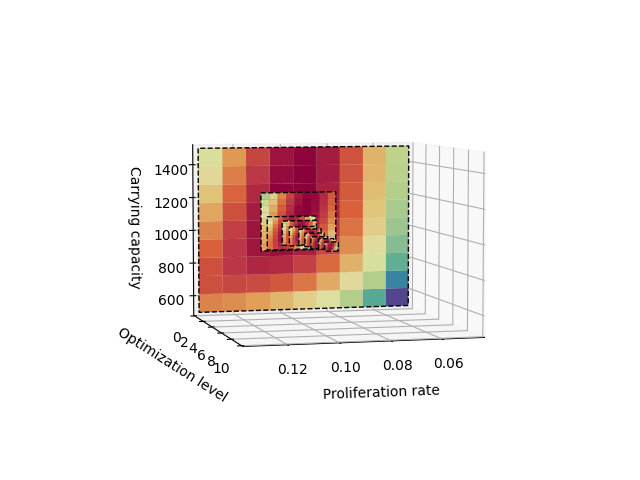

In [160]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ='3d')

fig.show()
fig.canvas.draw()

ax.view_init(elev=5., azim=75)

number_of_levels = 10
points_per_direction = 10
percent_per_direction = 0.5
about_point = np.array([0.09, 1000])

parameters_in_sweep = np.zeros((2,1))
objective_function = np.zeros((number_of_levels, points_per_direction, points_per_direction))
save_x = np.zeros((number_of_levels, points_per_direction))
save_y = np.zeros((number_of_levels, points_per_direction))

for n in range(number_of_levels):
    
    # Defining search bounds
    factor = percent_per_direction/(n*2+1)
    # Proliferation rate bounds
    min_prol_limit = about_point[0]-factor*about_point[0]
    max_prol_limit = about_point[0]+factor*about_point[0]
    prol_sweep = np.linspace(min_prol_limit, max_prol_limit, points_per_direction)
    # Carrying capacity bounds 
    min_carcap_limit = about_point[1]-factor*about_point[1]
    max_carcap_limit = about_point[1]+factor*about_point[1]
    carcap_sweep = np.linspace(min_carcap_limit, max_carcap_limit, points_per_direction)
    
    save_x[n] = prol_sweep
    save_y[n] = carcap_sweep
    
    # Sweep through the parameter combinations
    for a in range(points_per_direction):
        for b in range(points_per_direction):
            
            # Select parameters and run the model
            parameters_in_sweep[0] = prol_sweep[a]
            parameters_in_sweep[1] = carcap_sweep[b]
            N_model = logistic_growth_model(N_0, time, parameters_in_sweep)
            
            # Compute error
            objective_function[n][a][b] = sum_squared_diff(N_model, N_data)

    # Select best point in the parameter space
    # I is optimal index, but in references to a points_per_direction X points_per_direcion
    I = np.argmin(objective_function[n])
    x = int(np.floor(I/points_per_direction))
    y = int(I-points_per_direction*x)
    
    about_point[0] = prol_sweep[x]
    about_point[1] = carcap_sweep[y]
    
    # Get the parameter space
    x, y = np.meshgrid(save_x[n], save_y[n])
    
    width = max(save_x[n]) - min(save_x[n])
    heigth = max(save_y[n]) - min(save_y[n])
    
    p = Rectangle((min(save_x[n]), min(save_y[n])), width, heigth, 
                  edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=n, zdir='y')
    
    # Convert the error data to colormap
    color_dimension = objective_function[n] # change to desired fourth dimension
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm, cmap='Spectral')
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    # Plot surface using color as a 4th dimension
    ax.plot_surface(x, np.ones((len(prol_sweep), len(prol_sweep)))*n, y,
                    facecolors=fcolors,
                    edgecolor='white', linewidth=0.1, rstride=1, cstride=1,
                    vmin=minn, vmax=maxx)
    ax.set_ylim(0,10)
    ax.set_xlim(min(save_x[0]), max(save_x[0]))
    ax.set_zlim(min(save_y[0]), max(save_y[0]))
    
    fig.canvas.draw()

    ax.set_xlabel('Proliferation rate', labelpad=10)
    ax.set_zlabel('Carrying capacity', labelpad=10)
    ax.set_ylabel('Optimization level', labelpad=5)


## Helper functions

In [3]:
def sum_squared_diff(model_data, reference_data):
    """Returns the summ of the squared differences between model and reference data."""
    error = ((model_data - reference_data)**2).sum()
    
    return error

def logistic_growth_model(N_0, time, parameters):
    """Returns a NumPy array with the number of cells through time for logistic growth."""
    cells = np.array(np.shape(time))
    cells = parameters[1]*N_0/(N_0 + (parameters[1]-N_0)*np.exp(-parameters[0]*time))
                                                                
    return cells

def plot_growth(time, data, ax, title, ylabel=True):
    """Plots and styles the evolution of cell number through time."""
    ax.scatter(time, data, s=30)
    
    ax.grid(axis='y', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if ylabel is True:
        ax.set_ylabel('Number of Tumor Cells', fontsize=12, labelpad=10)
        
    ax.set_xlabel('Time (Days)', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=12, y=1.05)
    
    return ax